In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import lightgbm as lgbm
from tabulate import tabulate

from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

In [2]:
def treat_data(df_1):
    new_keys = ["Municipio"]
    tags = ["Total", "Primario", "Secundario"]
    new_keys += ["Plantas de tratamiento en operación: " + tag for tag in tags]
    new_keys += ["Capacidad instalada (Litros por segundo): " + tag for tag in tags]
    new_keys += ["Volumen tratado   (Millones de metros cúbicos): " + tag for tag in tags]
    df_1 = df_1.set_axis(new_keys, axis = 1)
    df_1 = df_1.drop([0,1,2], axis = 0).reset_index().drop("index", axis = 1)
    
    
    lista_municipios = []
    mun_row = df_1["Municipio"]
    indice_ultimo_municipio = 0
    
    for i in range(len(mun_row)):
        municipio = mun_row[i]
        if municipio not in ["Público", "Privado"]:
            indice_ultimo_municipio = i
            lista_municipios.append(municipio)
        else:
            lista_municipios.append(mun_row[indice_ultimo_municipio])
    
    df_1["Municipio_nuevo"] = lista_municipios
    
    for i in range(len(df_1)):
        if df_1["Municipio"].loc[i] not in ["Público", "Privado"]:
            df_1 = df_1.drop(i, axis = 0)
    df_1 = df_1.rename(columns = {"Municipio": "Tipo"})
    df_1 = df_1.rename(columns = {"Municipio_nuevo": "Municipio"})
    key = ["Municipio"] + list(df_1.keys()[:-1])
    df_1 = df_1[key].reset_index().drop("index", axis = 1)
    return(df_1)

In [3]:
def difference(p1, p2):
    dif = np.sqrt(np.sum(((p1 - p2))**2))
    return dif

In [4]:
data = pd.read_csv("Datos_limpios.csv", index_col = 0).drop(["Plantas de tratamiento en operación: Total", "Capacidad instalada (Litros por segundo): Total", "Volumen tratado   (Millones de metros cúbicos): Total", "Viviendas particulares habitadas con agua entubada"], axis = 1)
data = data.replace('NS',np.NaN)
data = data.dropna().reset_index(drop = True)
data

,Municipio,Tipo,Plantas de tratamiento en operación: Primario,Plantas de tratamiento en operación: Secundario,Capacidad instalada (Litros por segundo): Primario,Capacidad instalada (Litros por segundo): Secundario,Volumen tratado (Millones de metros cúbicos): Primario,Volumen tratado (Millones de metros cúbicos): Secundario,Diaria,Cada tercer día,Una o dos veces a la semana,Esporádica,No especificado
0,Acateno,Público,0,1,0,1.8,0,0.06,57.731158,26.495726,10.334110,4.351204,1.087801
1,Acatlán,Privado,1,0,1.25,0,1.25,0,3.887312,19.960690,70.037126,5.678096,0.436777
2,Ahuacatlán,Público,0,3,0,56,0,1.77,66.775244,18.494390,10.821571,3.764025,0.144770
3,Ajalpan,Privado,2,0,6.1,0,0.1,0,19.783085,25.195537,39.409740,15.465638,0.146001
4,Aljojuca,Público,0,2,0,8.54,0,0.2693,32.111252,43.994943,19.721871,3.919090,0.252845
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Xicotepec,Privado,0,11,0,23.5,0,0.7,81.995413,12.324609,2.091203,3.494334,0.094441
58,Xochiltepec,Público,0,1,0,5.2,0,0.164,36.514523,58.644537,3.319502,1.521438,0.000000
59,Zacapoaxtla,Público,0,1,0,2.7,0,0.0852,50.369588,29.809926,16.800422,2.893347,0.126716
60,Zacatlán,Público,1,2,20,81.11,0.3784,2.5579,63.752389,24.582280,10.123929,1.276281,0.265121


In [5]:
x = pd.get_dummies(data.Tipo, sparse=True).to_numpy()
train_data = data.to_numpy()
X = X_train = np.column_stack([x, train_data[:,2:8]]).astype(float)
y = y_train = train_data[:,8:]/100

In [6]:
svr = SVR()
rfr = RandomForestRegressor()

mor_svr = MultiOutputRegressor(svr)
mor_svr = mor_svr.fit(X_train, y_train)

mor_rfr = MultiOutputRegressor(rfr)
mor_rfr = mor_rfr.fit(X_train, y_train)

In [7]:
X_pred = pd.read_excel("X_2017.xlsx", skipfooter = 6, skiprows = range(6)).dropna(axis = 1, thresh = 10)
X_pred = treat_data(X_pred)
X_pred = X_pred.replace('NS',np.NaN)
X_pred = X_pred.dropna().reset_index(drop = True)
pred_dataset = X_pred

x = pd.get_dummies(X_pred.Tipo, sparse=True).to_numpy()
pred_data = X_pred.to_numpy()

X_pred = np.column_stack([x, pred_data[:,2:8]]).astype(float)
y_pred_svr = mor_svr.predict(X_pred)

y_pred_norm_svr = y_pred_svr/np.asarray([y.sum() for y in y_pred_svr]).reshape(-1,1)
percentages = (np.round(y_pred_norm_svr, 2)*100).astype(int)
pred_data = np.column_stack((pred_dataset["Municipio"].to_numpy(), percentages))
head = ["Municipio", "Diaria", "Cada tercer día", "Una o dos veces a la semana", "Esporádica", "No especificado"]
print("Resultados por SVM:\n" + tabulate(pred_data, headers = head, tablefmt = "rounded_outline"))

Resultados por SVM:
╭──────────────────────────────┬──────────┬───────────────────┬───────────────────────────────┬──────────────┬───────────────────╮
│ Municipio                    │   Diaria │   Cada tercer día │   Una o dos veces a la semana │   Esporádica │   No especificado │
├──────────────────────────────┼──────────┼───────────────────┼───────────────────────────────┼──────────────┼───────────────────┤
│ Acajete                      │       48 │                28 │                            12 │            9 │                 3 │
│ Acateno                      │       34 │                28 │                            22 │           12 │                 4 │
│ Acatlán                      │       41 │                28 │                            17 │           10 │                 3 │
│ Acatzingo                    │       34 │                28 │                            22 │           12 │                 4 │
│ Albino Zertuche              │       34 │                28 │

In [8]:
y_pred_rfr = mor_rfr.predict(X_pred)

y_pred_norm_rfr = y_pred_rfr/np.asarray([y.sum() for y in y_pred_rfr]).reshape(-1,1)
percentages = (np.round(y_pred_norm_rfr, 2)*100).astype(int)
pred_data = np.column_stack((pred_dataset["Municipio"].to_numpy(), percentages))
head = ["Municipio", "Diaria", "Cada tercer día", "Una o dos veces a la semana", "Esporádica", "No especificado"]
print("Resultados por Random Forest:\n" + tabulate(pred_data, headers = head, tablefmt = "rounded_outline"))

Resultados por Random Forest:
╭──────────────────────────────┬──────────┬───────────────────┬───────────────────────────────┬──────────────┬───────────────────╮
│ Municipio                    │   Diaria │   Cada tercer día │   Una o dos veces a la semana │   Esporádica │   No especificado │
├──────────────────────────────┼──────────┼───────────────────┼───────────────────────────────┼──────────────┼───────────────────┤
│ Acajete                      │       42 │                26 │                            18 │           12 │                 2 │
│ Acateno                      │       28 │                31 │                            26 │           12 │                 2 │
│ Acatlán                      │       43 │                26 │                            17 │           12 │                 2 │
│ Acatzingo                    │       28 │                31 │                            26 │           12 │                 2 │
│ Albino Zertuche              │       32 │          

In [9]:
diff = []
for i in range(len(y_pred_rfr)):
    dif = difference(y_pred_norm_rfr[i], y_pred_norm_svr[i])
    diff.append(dif)
    
print(f"Diferencia media entre modelos: {np.mean(diff)}")

Diferencia media entre modelos: 0.08103613293248134


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as met

mse = met.make_scorer(met.mean_squared_error)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

svr = SVR()
clf = MultiOutputRegressor(svr)
svr_scores = np.sqrt(cross_val_score(clf, X, y, cv=30, scoring = mse))*100

print(f"RMSE promedio del SVR: {np.mean(svr_scores)}")

rfr = RandomForestRegressor()
clf = MultiOutputRegressor(rfr)
rfr_scores = np.sqrt(cross_val_score(clf, X, y, cv=30, scoring = mse))*100
print(f"RMSE promedio del RFR: {np.mean(rfr_scores)}")

RMSE promedio del SVR: 15.5150244552468
RMSE promedio del RFR: 17.581419950008467


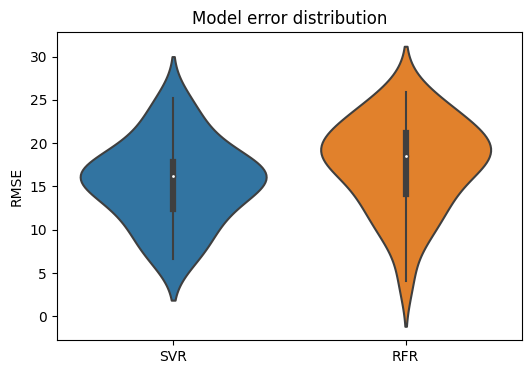

In [11]:
fig = plt.figure(figsize = (6, 4))

scores_df = pd.DataFrame()
scores_df["SVR"] = svr_scores
scores_df["RFR"] = rfr_scores

plt.ylabel("RMSE")
plt.title("Model error distribution")
sns.violinplot(data = scores_df)
fig.savefig("Violinplot.png", format = "png", dpi = 300)
plt.show()

In [22]:
from sklearn.model_selection import GridSearchCV
parameters = {'estimator__kernel':(['rbf']), 'estimator__C':np.arange(1, 100)/100}
svr = SVR()
mor = MultiOutputRegressor(svr)
clf = GridSearchCV(mor, parameters)
clf.fit(X, y)

GridSearchCV(estimator=MultiOutputRegressor(estimator=SVR()),
             param_grid={'estimator__C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                         'estimator__kernel': ['rbf']})

In [23]:
clf.best_params_

{'estimator__C': 0.46, 'estimator__kernel': 'rbf'}

RMSE promedio del SVR: 15.4636263200509


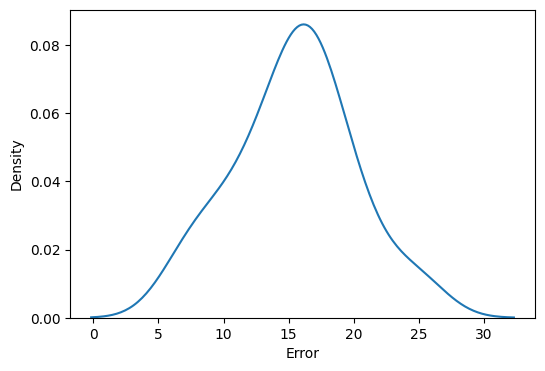

In [14]:
svr = SVR(kernel = "rbf", C = 0.46)
clf = MultiOutputRegressor(svr)

mse = met.make_scorer(met.mean_squared_error)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

svr_scores = np.sqrt(cross_val_score(clf, X, y, cv=30, scoring = mse))*100

print(f"RMSE promedio del SVR: {np.mean(svr_scores)}")

fig = plt.figure(figsize = (6, 4))
sns.kdeplot(x = svr_scores)
plt.xlabel("Error")
fig.savefig("KDE error.png", format = "png", dpi = 300)
plt.show()

In [15]:
svr = SVR(kernel = "rbf", C = 0.46)
mor = MultiOutputRegressor(svr)
mor.fit(X, y)

MultiOutputRegressor(estimator=SVR(C=0.46))

In [24]:
y_pred_svr = mor_svr.predict(X_pred)

y_pred_norm_svr = y_pred_svr/np.asarray([y.sum() for y in y_pred_svr]).reshape(-1,1)
percentages = (y_pred_norm_svr*100).astype(int)
pred_data = np.column_stack((pred_dataset["Municipio"].to_numpy(), percentages))
head = ["Municipio", "Diaria", "Cada tercer día", "Una o dos veces a la semana", "Esporádica", "No especificado"]
table = tabulate(pred_data, headers = head, tablefmt = "csv")
print("Resultados por SVM:\n" + table)


Resultados por SVM:
Municipio                       Diaria    Cada tercer día    Una o dos veces a la semana    Esporádica    No especificado
----------------------------  --------  -----------------  -----------------------------  ------------  -----------------
Acajete                             47                 28                             12             8                  3
Acateno                             33                 28                             22            11                  3
Acatlán                             40                 28                             17            10                  3
Acatzingo                           33                 28                             22            11                  3
Albino Zertuche                     34                 28                             22            11                  3
Aljojuca                            35                 28                             21            11                  3
Amoz

In [18]:
df = pd.DataFrame(pred_data)
df.columns = head
df.to_csv("output.csv")